# Train U-Net

## Imports

In [9]:
import os
import random

import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Change GPU setting

In [5]:
# Limit number of GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Limit GPU memory
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)

## Create and Compile U-Net

<img src='images/unet.png' width='600'/>

For the convolutional layers we use "padding = same". This adds extra pixles along the edges of the image so that the 3x3 convolution covers the whole image. Because of this the dimensions of the output image is the same as the input image. This is not the case with the image above as we see that the pixels of the image changes from 572x572 to 570x570 in the first convolution.
<br>
<br>
In between the convolutional layers we will make use of "dropout". This is to prevent overfitting.
<br>
<br>
Kernel initializer is the starting weight of the layers. "he_normal" picks a starting value from a truncated normal distribution.
<br>
<br>
Optimizer the choice of a module that contains back propagation algorithms.
<br>
<br>
Loss is the function that the optimizer is trying to minimize.

In [10]:
# Creating the model
def unet(input_size=(512, 512, 3)):
    # Encoder Part
    # Layer 1
    inputs = layers.Input(input_size)
    inputs_rescaled = layers.Lambda(lambda x: x / 255)(inputs) # Rescale input pixel values to floating point values
    c1 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(inputs_rescaled)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    # Layer 2
    c2 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    # Layer 3
    c3 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = layers.Dropout(0.1)(c3)
    c3 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)
    
    # Layer 4
    c4 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)
    
    # Layer 5
    c5 = layers.Conv2D(1024, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = layers.Dropout(0.1)(c5)
    c5 = layers.Conv2D(1024, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)
    
    
    # Decoder Part
    # Layer 6
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding = 'same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = layers.Dropout(0.1)(c6)
    c6 = layers.Conv2D(512, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
    
    # Layer 7
    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding = 'same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
    
    # Layer 8
    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding = 'same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)
    
    # Layer 9
    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding = 'same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
    
    outputs = layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)
    
    # Compiling model
    model = models.Model([inputs], [outputs])
    model.compile(optimizer = 'adam', loss = losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
    
    return model

In [11]:
model = unet((512, 512, 4))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 512, 512, 4)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  2368        ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

                                                                                                  
 conv2d_32 (Conv2D)             (None, 128, 128, 25  590080      ['dropout_15[0][0]']             
                                6)                                                                
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 256, 256, 12  131200     ['conv2d_32[0][0]']              
 spose)                         8)                                                                
                                                                                                  
 concatenate_6 (Concatenate)    (None, 256, 256, 25  0           ['conv2d_transpose_6[0][0]',     
                                6)                                'conv2d_22[0][0]']              
                                                                                                  
 conv2d_33

## Preparing data

In [14]:
train_set = 'rgbLiDAR'
mask = 'mask'
color_mode = 'rgba'

In [15]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

seed = 24
batch_size = 6

img_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.


image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_train/' + train_set),
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           color_mode=color_mode,
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_train/' + mask),
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

val_data_generator = ImageDataGenerator()
valid_img_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_validation/' + train_set),
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode=color_mode,
                                                               class_mode=None)

valid_mask_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_validation/' + mask),
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)

train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

num_train_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/preprocessed_train/' + train_set + '/train')))
num_val_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/preprocessed_validation/' + train_set + '/val')))
train_steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_imgs // batch_size

Found 7000 images belonging to 1 classes.
Found 7000 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.


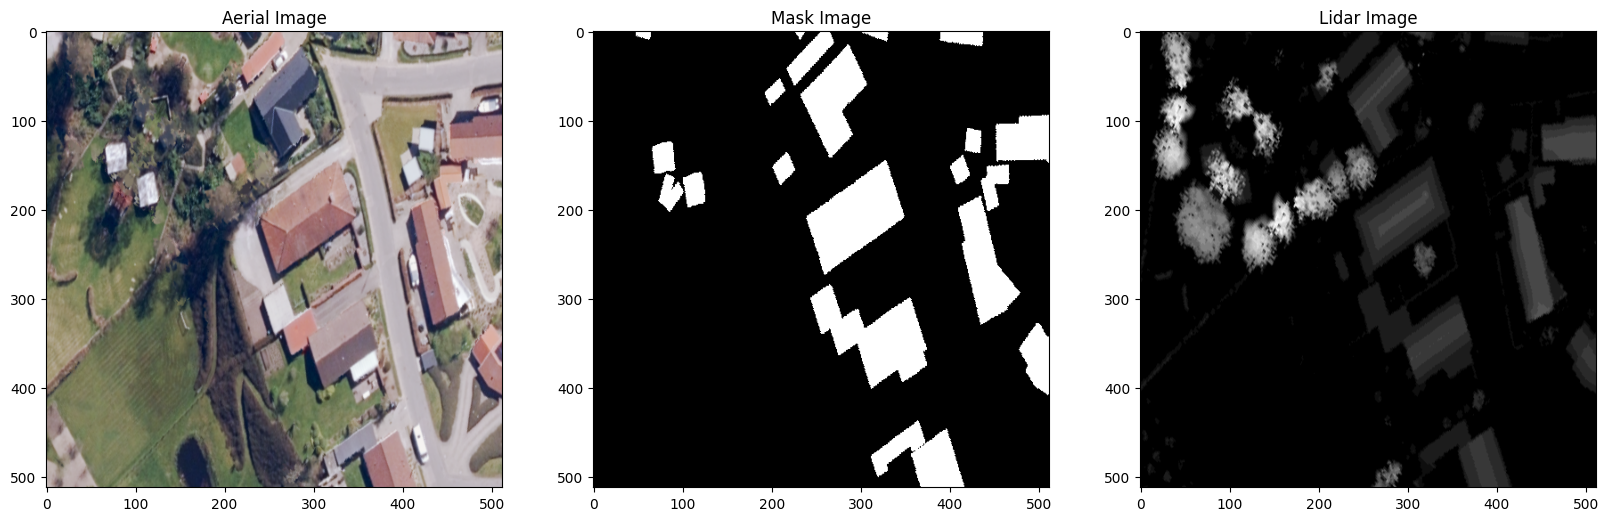

In [18]:
imggen = image_generator.next()
maskkgen = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(20,20))
    image = imggen[i]
    mask = maskkgen[i]
    
    # Find and display aerial image
    plt.subplot(131)
    plt.title('Aerial Image')
    aerial_img = cv.cvtColor(image[:, :, 0:3], cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img.astype(np.uint8))
    
    # Find and display mask image
    plt.subplot(132)
    plt.title('Mask Image')
    plt.imshow(mask, cmap='gray')
    
    # Find and display lidar image
    plt.subplot(133)
    plt.title('Lidar Image')
    plt.imshow(image[:, :, 3], cmap='gray')
    plt.show()

## Train Model

In [ ]:
# Create callback for model.
# ModelCheckpoint -> Creates checkpoints after each epoch
# EarlyStopping -> Stops the training of the model if it doesnt improve after some epochs
callback_list = [
    callbacks.ModelCheckpoint(os.path.normpath('../models/MapAI_UNet_Task1_Checkpoint.h5'), verbose=1, save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=6),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
]

# Train the model
results = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=100, callbacks=callback_list, validation_data=val_generator, validation_steps=val_steps_per_epoch)


Epoch 1/25


In [ ]:
# Save model
model.save(os.path.normpath('models/unet1'))